In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from networkx.algorithms.community.louvain import modularity, louvain_communities
import netwulf as nw
from collections import Counter, defaultdict
import random
from tqdm import tqdm

#import pandas as pd
#df = pd.read_pickle("lyrics_sentiment.pkl")

with open("../artist_data_pickle.pth", "rb") as f:
    artists = pickle.load(f)

In [2]:
# Create a graph
MG = nx.MultiGraph()
for name, data in artists.items():
    related_artists = data['related']
    genres = data['genres']
    MG.add_node(name, genres=genres, id=data['id'])

for name, data in artists.items():
    related_artists = data['related']
    for i,related_artist in enumerate(related_artists):
        MG.add_edge(name, related_artist,weight=1-i/len(related_artists))
        
#Remove isolated nodes
MG.remove_nodes_from(list(nx.isolates(MG)))
G = nx.Graph(MG)
#Merge over parallel edges averaging the weights
for u in MG.nodes:
    for v in MG.neighbors(u):
        if u == v:
            continue
        weight = 0
        n = 0
        for e, w in G[u][v].items():
            weight += w
            n += 1
        G[u][v]['weight'] = weight/n
del MG

In [3]:
len(G.nodes), len(G.edges)

(90782, 459109)

In [4]:
louvain_partition = louvain_communities(G)

In [5]:
genre_commonality = Counter()
artist_degrees_dist = Counter()
for artist_name, data in artists.items():
    for genre in data['genres']:
        genre_commonality[genre] += 1
    artist_degrees_dist[len(data['related'])] += 1

In [6]:
genre_artists = defaultdict(set)
for artist_name, data in artists.items():
    if len(data['genres']) > 0:
        data['most_common_genre'] = max(data['genres'], key=genre_commonality.get)
    else:
        data['most_common_genre'] = 'None'
    if artist_name in G:
        genre_artists[data['most_common_genre']].add(artist_name)
        
genre_partition = list(genre_artists.values())

In [7]:
def random_network(G):
    #Copy graph: (MultiGraph because self-loops are allowed and parallel edges are allowed)
    G_c = nx.MultiGraph(G)
    #Create lists of source and target nodes:
    sources, targets = zip(*G.edges)
    #Concatenate sources and targets into a unique list:
    stubs = list(sources) + list(targets)
    #Shuffle the list of stubs:
    random.shuffle(stubs)
    #Build a set of edges (tuples) by connecting each element in the list of shuffled stubs with the following element:
    edges = [(stubs[i], stubs[i+1]) for i in range(0,len(stubs)-1,2)]
    #Remove all the original network edges from your network:
    G_c.remove_edges_from(G.edges)
    #Add all the new shuffled edges you created in step d:
    G_c.add_edges_from(edges)
    return G_c

In [8]:
louvain_modularities = []
try:
    with open('./louvain_random_modularities.pkl', 'rb') as f:
        louvain_modularities = pickle.load(f)
except:
    for _ in tqdm(range(1000)):
        louvain_modularities.append(modularity(random_network(G), louvain_partition))

In [9]:
genre_modularities = []
try:
    with open('./genre_random_modularities.pkl', 'rb') as f:
        genre_modularities = pickle.load(f)
except:
    for _ in tqdm(range(1000)):
        genre_modularities.append(modularity(random_network(G), genre_partition))

In [12]:
louvain_mod = modularity(G, louvain_partition)
genre_mod = modularity(G, genre_partition)
print(f'Louvain partition modularity: {louvain_mod:.4g}')
print(f'Popular Genre partition modularity: {genre_mod:.4g}')

Louvain partition modularity: 0.8833
Popular Genre partition modularity: 0.4174


Text(0.5, 0, 'Modularity')

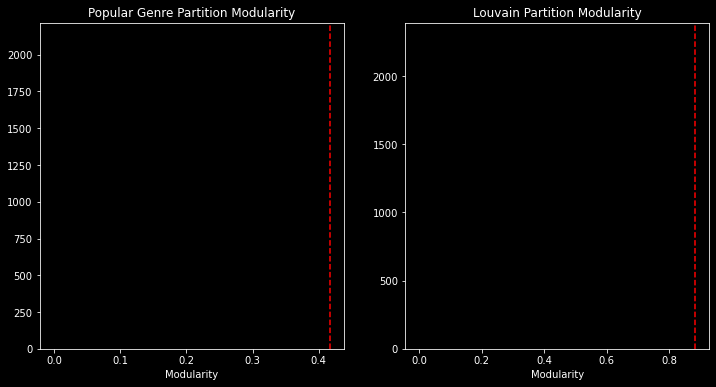

In [13]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].hist(genre_modularities, bins=100, density=True)
axs[0].axvline(x=genre_mod, color='r', linestyle='--')
axs[0].set_title('Popular Genre Partition Modularity')
axs[0].set_xlabel('Modularity')
axs[1].hist(louvain_modularities, bins=100, density=True)
axs[1].axvline(x=louvain_mod, color='r', linestyle='--')
axs[1].set_title('Louvain Partition Modularity')
axs[1].set_xlabel('Modularity')

In [27]:
import colorsys
#Generate colors for each of the GME_lou_comm
def color_generator(n):
    #Force value in HSV space to be 1.0
    h = 0.0
    s = 1.0
    v = 1.0
    #Generate a list of colors
    colors = []
    revolutions = 0
    rot = 1/8
    for i in range(n):
        #Generate a color from the HSV space
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        #Convert to hex
        hex_color = "#{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255))
        #Add to list
        colors.append(hex_color)
        #Increment hue
        h += rot
        if (i+1) % (8**revolutions) == 0:
            revolutions += 1
            rot = (1/8)**revolutions
            h = rot
    return colors

In [16]:
#list of four colors
node_color = color_generator(len(louvain_partition))
node_color_dict = {n: node_color[i] for i, nodes in enumerate(louvain_partition) for n in nodes}
nx.set_node_attributes(G, node_color_dict, "color")

G_louvain, config = nw.visualize(G)
nw.save("G_positions.json", G_louvain, config)

In [33]:
import matplotlib.patheffects as pe
G_positions, config, _ = nw.load("G_positions.json")
fig, ax = nw.draw_netwulf(G_positions, config, figsize=16, draw_links=False)
#Get the max nodes for each community
G_top_nodes = [max(comm, key=lambda x: G.degree(x)) for comm in louvain_partition]
for n in G_top_nodes:
    nw.add_node_label(ax, G_positions, n, fontsize=7, fontweight='bold',
              path_effects=[pe.withStroke(linewidth=2, foreground="black")])
    
#Save as SVG:
fig.savefig('louvain_network.svg', format='svg', dpi=1200)
print("Saved to louvain_network.svg")
plt.close()

Saved to louvain_network.svg


C:\Users\Anders\AppData\Local\Temp\ipykernel_9336\3518492722.py:11: UserWarning: Glyph 24859 (\N{CJK UNIFIED IDEOGRAPH-611B}) missing from current font.
  fig.savefig('louvain_network.svg', format='svg', dpi=1200)


In [35]:
import matplotlib.patheffects as pe
node_color = color_generator(len(genre_partition))
node_color_dict = {n: node_color[i] for i, nodes in enumerate(sorted(genre_partition, key=lambda x: len(x), reverse=True)) for n in nodes}
nx.set_node_attributes(G, node_color_dict, "color")
G_positions, config, _ = nw.load("G_positions.json")
for data in G_positions['nodes']:
    data['color'] = node_color_dict[data['id']]
fig, ax = nw.draw_netwulf(G_positions, config, figsize=16, draw_links=False)
#Get the max nodes for each community
G_top_nodes = sorted([max(comm, key=lambda x: G.degree(x)) for comm in genre_partition], key=lambda x: G.degree(x), reverse=True)[:100]
for n in G_top_nodes:
    nw.add_node_label(ax, G_positions, n, f"{n}[{artists[n]['most_common_genre']}]", fontsize=7, fontweight='bold',
              path_effects=[pe.withStroke(linewidth=2, foreground="black")])
#Save as SVG:
fig.savefig('genre_network.svg', format='svg', dpi=1200)
print("Saved to genre_network.svg")
plt.close()

Saved to genre_network.svg


C:\Users\Anders\AppData\Local\Temp\ipykernel_9336\3541282175.py:15: UserWarning: Glyph 24859 (\N{CJK UNIFIED IDEOGRAPH-611B}) missing from current font.
  fig.savefig('genre_network.svg', format='svg', dpi=1200)


In [36]:
with open('./sentiment_analysis_data.pkl', 'rb') as f:
    sentiment_analysis_data = pickle.load(f)

In [80]:
artist_emotion = sentiment_analysis_data['artist_emotion']
mean_emotion = sentiment_analysis_data['mean_emotion']
artist_sentiment = sentiment_analysis_data['artist_sentiment']
mean_sentiment = sentiment_analysis_data['mean_sentiment']

In [126]:
import matplotlib.patheffects as pe
def norm_clamp(val, mu, std):
    #Should span from 5% to 95%
    h = (val - mu) / (std * 2)
    h = max(0, min(1, h*0.5+0.5))
    return h

def gradient_hex(val, mean, stdandard_deviation):
    #Gradient from green to red based on value.
    h = norm_clamp(val, mean, stdandard_deviation)
    h = h * 0.33
    r, g, b = colorsys.hsv_to_rgb(h, 1.0, 1.0)
    hex_color = "#{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255))
    return hex_color
sen_mu = np.mean([v-mean_sentiment for v in artist_sentiment.values()])
sen_std = np.std([v-mean_sentiment for v in artist_sentiment.values()])
emo_mu = np.mean([v-mean_emotion for v in artist_emotion.values()])
emo_std = np.std([v-mean_emotion for v in artist_emotion.values()])
sentiment_color_dict = {n: gradient_hex(v-mean_sentiment,sen_mu,sen_std) for n, v in artist_sentiment.items()}
emotion_radius_dict = {n: 0.01+3*norm_clamp(v-mean_emotion,emo_mu,emo_std)**2 for n, v in artist_emotion.items()}

G_positions, _, _ = nw.load("G_positions.json")

for data in G_positions['nodes']:
    if data['id'] in sentiment_color_dict:
        data['color'] = sentiment_color_dict[data['id']]
        data['radius'] = emotion_radius_dict[data['id']]

G_positions['links'] = []
G_positions['nodes'] = [data for data in G_positions['nodes'] if data['id'] in sentiment_color_dict]
fig, ax = nw.draw_netwulf(G_positions, figsize=16, draw_links=False)
#Get the most sentimentful nodes
G_top_nodes = sorted(artist_sentiment.keys(), key=lambda x: artist_sentiment[x], reverse=True)[:50]+sorted(artist_sentiment.keys(), key=lambda x: artist_sentiment[x], reverse=False)[:50]+sorted(artist_emotion.keys(), key=lambda x: artist_emotion[x], reverse=True)[:50]
for n in G_top_nodes:
    nw.add_node_label(ax, G_positions, n, f"{n}[{artists[n]['most_common_genre']}]", fontsize=1+5*norm_clamp(artist_emotion[n]-mean_emotion,emo_mu,emo_std), fontweight='bold', 
              path_effects=[pe.withStroke(linewidth=0.35, foreground=gradient_hex(artist_sentiment[n]-mean_sentiment,sen_mu,sen_std))])
#Save as SVG:
fig.savefig('sentiment_network.svg', format='svg', dpi=1200)
print("Saved to sentiment_network.svg")
plt.close()

Saved to sentiment_network.svg


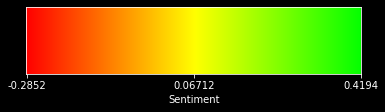

In [120]:
#Generate colorbar
colorbar = np.zeros((100,500,3))
for i,v in enumerate(np.linspace(0,1,500)):
    #Gradient from green to red based on value and min/max
    v = v * 0.33
    r, g, b = colorsys.hsv_to_rgb(v, 1.0, 1.0)
    colorbar[:,i,:] = np.array([r,g,b])
plt.imshow(colorbar)
#y-axis off
plt.yticks([])
plt.xticks(np.linspace(0,500,3), [f"{sen_mu - sen_std*2:.4g}", f"{sen_mu:.4g}", f"{sen_mu + sen_std*2:.4g}"])
plt.xlabel("Sentiment")
plt.savefig('colorbar.svg', format='svg', dpi=1200)

In [89]:
positive_negative_sent = [(v-mean_sentiment) > 0 for v in artist_sentiment.values()]
print(f"Positive sentiment: {sum(positive_negative_sent)}")
print(f"Negative sentiment: {len(positive_negative_sent)-sum(positive_negative_sent)}")

Positive sentiment: 27113
Negative sentiment: 14827


In [112]:
min([n['radius'] for n in G_positions['nodes']])

0.09838129741489134